# 환경설치

In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 필요한 라이브러리 설치 (코랩에서 실행)
!pip install torch torchvision matplotlib seaborn pandas numpy Pillow scikit-learn

# 기본 라이브러리 import
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import os

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정 (재현 가능한 결과를 위해)
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

 가상 이미지 데이터셋 생성 중...
 생성 완료!
   - 이미지 개수: 500
   - 이미지 크기: (3, 64, 64)
   - 클래스 개수: 5
   - 전체 데이터 크기: torch.Size([500, 3, 64, 64])
   - 클래스별 분포: [88, 94, 102, 112, 104]

 이미지 데이터셋 샘플 확인:
   - 이미지 shape: torch.Size([3, 128, 128])
   - 이미지 dtype: torch.float32
   - 라벨: 3
   - 이미지 값 범위: [-2.084, 2.553]


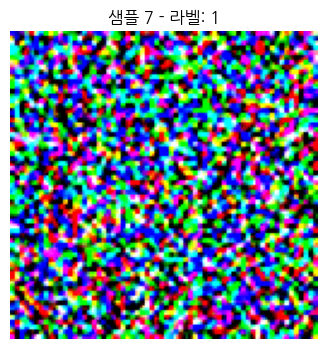

In [5]:
class FakeImageDataset(Dataset):
    """
    가상 이미지 데이터셋 (실제 파일 없이 테스트용)
    실제 프로젝트에서는 실제 이미지 파일을 사용합니다.
    """

    def __init__(self, num_samples=1000, image_size=(3, 64, 64), num_classes=10, transform=None):
        """
        Args:
            num_samples: 생성할 이미지 개수
            image_size: 이미지 크기 (채널, 높이, 너비)
            num_classes: 클래스 개수
            transform: 적용할 Transform
        """
        self.num_samples = num_samples
        self.image_size = image_size
        self.num_classes = num_classes
        self.transform = transform

        # 가상 이미지와 라벨 생성
        print(f" 가상 이미지 데이터셋 생성 중...")
        self.images = torch.randint(0, 256, (num_samples,) + image_size, dtype=torch.uint8)
        self.labels = torch.randint(0, num_classes, (num_samples,))

        print(f" 생성 완료!")
        print(f"   - 이미지 개수: {num_samples}")
        print(f"   - 이미지 크기: {image_size}")
        print(f"   - 클래스 개수: {num_classes}")
        print(f"   - 전체 데이터 크기: {self.images.shape}")

        # 클래스별 분포 확인
        class_counts = torch.bincount(self.labels, minlength=num_classes)
        print(f"   - 클래스별 분포: {class_counts.tolist()}")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 이미지와 라벨 가져오기
        image = self.images[idx]
        label = self.labels[idx]

        # PIL 이미지로 변환 (Transform 적용을 위해)
        pil_image = transforms.ToPILImage()(image)

        # Transform 적용
        if self.transform:
            image = self.transform(pil_image)
        else:
            image = transforms.ToTensor()(pil_image)

        return image, label

    def show_sample(self, idx=0):
        """샘플 이미지 시각화"""
        image, label = self[idx]

        plt.figure(figsize=(6, 4))

        # 이미지 표시 (채널이 첫 번째 차원인 경우 변환)
        if image.dim() == 3:
            img_to_show = image.permute(1, 2, 0)
        else:
            img_to_show = image

        plt.imshow(img_to_show)
        plt.title(f'샘플 {idx} - 라벨: {label}')
        plt.axis('off')
        plt.show()

# 이미지 Transform 정의
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),          # 크기 통일
    transforms.RandomHorizontalFlip(0.5),   # 랜덤 좌우반전
    transforms.ToTensor(),                  # Tensor 변환
    transforms.Normalize(                   # 정규화
        mean=[0.485, 0.456, 0.406],        # ImageNet 평균
        std=[0.229, 0.224, 0.225]          # ImageNet 표준편차
    )
])

# 이미지 데이터셋 생성
image_dataset = FakeImageDataset(
    num_samples=500,
    image_size=(3, 64, 64), # < >  (64,64,3) // RGB, jpg
    num_classes=5,
    transform=image_transform
)

# 샘플 확인
print(f"\n 이미지 데이터셋 샘플 확인:")
sample_image, sample_label = image_dataset[0]
print(f"   - 이미지 shape: {sample_image.shape}")
print(f"   - 이미지 dtype: {sample_image.dtype}")
print(f"   - 라벨: {sample_label}")
print(f"   - 이미지 값 범위: [{sample_image.min():.3f}, {sample_image.max():.3f}]")

# 시각화
image_dataset.show_sample(7)

CIFAR-10 실제 데이터셋

 CIFAR-10 데이터셋 다운로드 중...
 CIFAR-10 다운로드 완료!
   - 훈련 데이터: 50000개
   - 테스트 데이터: 10000개
   - 클래스 개수: 10
   - 훈련 배치 수: 1563
   - 테스트 배치 수: 313


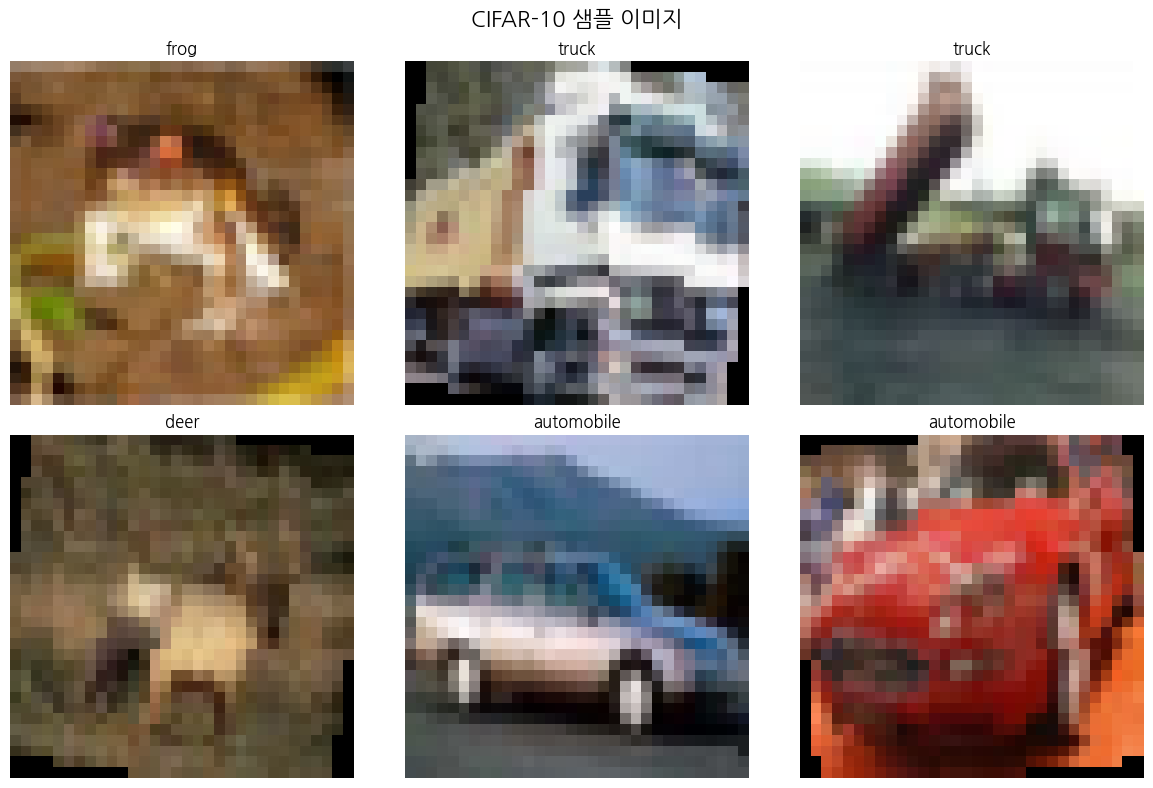

In [8]:
# CIFAR-10 데이터셋 다운로드 및 사용
print(" CIFAR-10 데이터셋 다운로드 중...")

# CIFAR-10 클래스 이름
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Transform 정의
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 데이터셋 로드
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

print(f" CIFAR-10 다운로드 완료!")
print(f"   - 훈련 데이터: {len(train_dataset)}개")
print(f"   - 테스트 데이터: {len(test_dataset)}개")
print(f"   - 클래스 개수: {len(cifar10_classes)}")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"   - 훈련 배치 수: {len(train_loader)}")
print(f"   - 테스트 배치 수: {len(test_loader)}")

# 샘플 시각화
def show_cifar_samples(dataset, num_samples=6):
    """CIFAR-10 샘플 시각화"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('CIFAR-10 샘플 이미지', fontsize=16)

    for i in range(num_samples):
        image, label = dataset[i]

        # 정규화 해제 (시각화를 위해)
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)

        # 이미지 표시
        row, col = i // 3, i % 3
        axes[row, col].imshow(image.permute(1, 2, 0))
        axes[row, col].set_title(f'{cifar10_classes[label]}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# CIFAR-10 샘플 시각화
show_cifar_samples(train_dataset)

# 텍스트 데이터셋

In [9]:
class SimpleTextDataset(Dataset):
    """간단한 텍스트 분류 데이터셋"""

    def __init__(self, texts, labels, max_length=100):
        """
        Args:
            texts: 텍스트 리스트
            labels: 라벨 리스트
            max_length: 최대 시퀀스 길이
        """
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

        # 어휘 사전 구축
        self.vocab = self._build_vocab()
        self.vocab_size = len(self.vocab)

        print(f" 텍스트 데이터셋 생성 완료!")
        print(f"   - 텍스트 개수: {len(texts)}")
        print(f"   - 어휘 사전 크기: {self.vocab_size}")
        print(f"   - 최대 길이: {max_length}")

        # 라벨 분포 확인
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"   - 라벨 분포: {dict(zip(unique_labels, counts))}")

    def _build_vocab(self):
        """어휘 사전 구축"""
        vocab = {'<PAD>': 0, '<UNK>': 1}  # 특수 토큰

        for text in self.texts:
            words = text.lower().split()
            for word in words:
                if word not in vocab:
                    vocab[word] = len(vocab)

        return vocab

    def _text_to_sequence(self, text):
        """텍스트를 숫자 시퀀스로 변환"""
        words = text.lower().split()
        sequence = []

        for word in words:
            if word in self.vocab:
                sequence.append(self.vocab[word])
            else:
                sequence.append(self.vocab['<UNK>'])

        # 패딩 또는 자르기
        if len(sequence) < self.max_length:
            # 패딩 추가
            sequence.extend([self.vocab['<PAD>']] * (self.max_length - len(sequence)))
        else:
            # 길이 제한
            sequence = sequence[:self.max_length]

        return sequence

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # 텍스트를 시퀀스로 변환
        sequence = self._text_to_sequence(text)

        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def decode_sequence(self, sequence):
        """숫자 시퀀스를 텍스트로 변환 (디버깅용)"""
        # 역방향 어휘 사전 생성
        idx_to_word = {idx: word for word, idx in self.vocab.items()}

        words = []
        for idx in sequence:
            word = idx_to_word.get(idx.item(), '<UNK>')
            if word != '<PAD>':
                words.append(word)

        return ' '.join(words)

# 예시 텍스트 데이터 생성
sample_texts = [
    "This movie is absolutely amazing and wonderful",
    "I hate this film it's terrible and boring",
    "Great acting and beautiful cinematography loved it",
    "Worst movie ever complete waste of time",
    "Fantastic story with excellent character development",
    "Boring plot nothing interesting happens at all",
    "Brilliant performance by all actors highly recommended",
    "Terrible script and poor directing very disappointing"
]

sample_labels = [1, 0, 1, 0, 1, 0, 1, 0]  # 1: 긍정, 0: 부정

# 텍스트 데이터셋 생성
text_dataset = SimpleTextDataset(sample_texts, sample_labels, max_length=15)

# 몇 개 샘플 확인
print(f"\n 텍스트 데이터셋 샘플 확인:")
for i in range(3):
    sequence, label = text_dataset[i]
    original_text = sample_texts[i]
    decoded_text = text_dataset.decode_sequence(sequence)

    print(f"\n샘플 {i}:")
    print(f"   원문: {original_text}")
    print(f"   변환: {decoded_text}")
    print(f"   시퀀스: {sequence[:10].tolist()}...")  # 처음 10개만 표시
    print(f"   라벨: {label.item()}")

# 텍스트 DataLoader 생성
text_loader = DataLoader(text_dataset, batch_size=4, shuffle=True)

# 배치 확인
batch_sequences, batch_labels = next(iter(text_loader))
print(f"\n 텍스트 배치 정보:")
print(f"   - 시퀀스 shape: {batch_sequences.shape}")
print(f"   - 라벨 shape: {batch_labels.shape}")
print(f"   - 배치 라벨들: {batch_labels.tolist()}")

 텍스트 데이터셋 생성 완료!
   - 텍스트 개수: 8
   - 어휘 사전 크기: 50
   - 최대 길이: 15
   - 라벨 분포: {np.int64(0): np.int64(4), np.int64(1): np.int64(4)}

 텍스트 데이터셋 샘플 확인:

샘플 0:
   원문: This movie is absolutely amazing and wonderful
   변환: this movie is absolutely amazing and wonderful
   시퀀스: [2, 3, 4, 5, 6, 7, 8, 0, 0, 0]...
   라벨: 1

샘플 1:
   원문: I hate this film it's terrible and boring
   변환: i hate this film it's terrible and boring
   시퀀스: [9, 10, 2, 11, 12, 13, 7, 14, 0, 0]...
   라벨: 0

샘플 2:
   원문: Great acting and beautiful cinematography loved it
   변환: great acting and beautiful cinematography loved it
   시퀀스: [15, 16, 7, 17, 18, 19, 20, 0, 0, 0]...
   라벨: 1

 텍스트 배치 정보:
   - 시퀀스 shape: torch.Size([4, 15])
   - 라벨 shape: torch.Size([4])
   - 배치 라벨들: [1, 0, 1, 0]


# 실제 텍스트 데이터셋 (영화 리뷰)

In [11]:
# 간단한 영화 리뷰 데이터셋 만들기
movie_reviews = [
    ("The storyline was captivating and the acting was superb", 1),
    ("Completely boring waste of two hours of my life", 0),
    ("Amazing visual effects and great soundtrack", 1),
    ("Poor dialogue and terrible character development", 0),
    ("One of the best films I have ever seen", 1),
    ("Confusing plot and bad acting throughout", 0),
    ("Brilliant cinematography and excellent direction", 1),
    ("Disappointing ending ruined the entire movie", 0),
    ("Fantastic performance by the lead actor", 1),
    ("Overly long and extremely boring movie", 0),
    ("Creative story with unexpected plot twists", 1),
    ("Generic storyline nothing new or interesting", 0),
    ("Outstanding musical score and beautiful scenes", 1),
    ("Poorly written script with weak characters", 0),
    ("Engaging from start to finish loved every minute", 1)
]

# 데이터 분리
texts = [review for review, _ in movie_reviews]
labels = [label for _, label in movie_reviews]

# 훈련/테스트 분할
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f" 영화 리뷰 데이터셋:")
print(f"   - 전체 리뷰 수: {len(texts)}")
print(f"   - 훈련 데이터: {len(train_texts)}")
print(f"   - 테스트 데이터: {len(test_texts)}")
print(f"   - 긍정 리뷰: {sum(labels)}")
print(f"   - 부정 리뷰: {len(labels) - sum(labels)}")

# 데이터셋 생성
train_text_dataset = SimpleTextDataset(train_texts, train_labels, max_length=20)
test_text_dataset = SimpleTextDataset(test_texts, test_labels, max_length=20)

# DataLoader 생성
train_text_loader = DataLoader(train_text_dataset, batch_size=5, shuffle=True)
test_text_loader = DataLoader(test_text_dataset, batch_size=5, shuffle=False)

print(f"\n DataLoader 정보:")
print(f"   - 훈련 배치 수: {len(train_text_loader)}")
print(f"   - 테스트 배치 수: {len(test_text_loader)}")

# 어휘 사전 정보
print(f"\n 어휘 사전 정보:")
print(f"   - 전체 단어 수: {train_text_dataset.vocab_size}")
print(f"   - 자주 나오는 단어들:")

# 단어 빈도 계산
word_freq = {}
for text in train_texts:
    for word in text.lower().split():
        word_freq[word] = word_freq.get(word, 0) + 1

# 빈도 순으로 정렬
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
for word, freq in sorted_words[:10]:
    print(f"     - {word}: {freq}번")

 영화 리뷰 데이터셋:
   - 전체 리뷰 수: 15
   - 훈련 데이터: 10
   - 테스트 데이터: 5
   - 긍정 리뷰: 8
   - 부정 리뷰: 7
 텍스트 데이터셋 생성 완료!
   - 텍스트 개수: 10
   - 어휘 사전 크기: 56
   - 최대 길이: 20
   - 라벨 분포: {np.int64(0): np.int64(5), np.int64(1): np.int64(5)}
 텍스트 데이터셋 생성 완료!
   - 텍스트 개수: 5
   - 어휘 사전 크기: 33
   - 최대 길이: 20
   - 라벨 분포: {np.int64(0): np.int64(2), np.int64(1): np.int64(3)}

 DataLoader 정보:
   - 훈련 배치 수: 2
   - 테스트 배치 수: 1

 어휘 사전 정보:
   - 전체 단어 수: 56
   - 자주 나오는 단어들:
     - and: 6번
     - of: 3번
     - the: 3번
     - boring: 2번
     - storyline: 2번
     - was: 2번
     - acting: 2번
     - plot: 2번
     - completely: 1번
     - waste: 1번


# 텍스트 데이터 증강

In [12]:
class TextAugmentation:
    """텍스트 데이터 증강 클래스"""

    def __init__(self, aug_prob=0.1):
        self.aug_prob = aug_prob

        # 간단한 동의어 사전 (실제로는 WordNet 등 사용)
        self.synonyms = {
            'good': ['great', 'excellent', 'wonderful', 'amazing', 'fantastic'],
            'bad': ['terrible', 'awful', 'horrible', 'poor', 'dreadful'],
            'like': ['love', 'enjoy', 'appreciate', 'adore'],
            'movie': ['film', 'cinema', 'picture', 'flick'],
            'great': ['excellent', 'wonderful', 'amazing', 'fantastic', 'superb'],
            'terrible': ['awful', 'horrible', 'dreadful', 'appalling']
        }

        print(f" 텍스트 증강 도구 생성 (확률: {aug_prob})")
        print(f"   - 동의어 사전 크기: {len(self.synonyms)}")

    def synonym_replacement(self, text, num_replacements=1):
        """동의어 치환"""
        words = text.split()
        new_words = words.copy()

        replacements_made = 0
        indices = list(range(len(words)))
        np.random.shuffle(indices)

        for idx in indices:
            if replacements_made >= num_replacements:
                break

            word = words[idx].lower()
            if word in self.synonyms:
                synonym = np.random.choice(self.synonyms[word])
                new_words[idx] = synonym
                replacements_made += 1

        return ' '.join(new_words)

    def random_insertion(self, text, num_insertions=1):
        """랜덤 단어 삽입"""
        words = text.split()

        # 모든 동의어 수집
        all_synonyms = []
        for synonym_list in self.synonyms.values():
            all_synonyms.extend(synonym_list)

        for _ in range(num_insertions):
            new_word = np.random.choice(all_synonyms)
            random_idx = np.random.randint(0, len(words) + 1)
            words.insert(random_idx, new_word)

        return ' '.join(words)

    def random_deletion(self, text, delete_prob=0.1):
        """랜덤 단어 삭제"""
        words = text.split()

        if len(words) == 1:
            return text

        new_words = []
        for word in words:
            if np.random.random() > delete_prob:
                new_words.append(word)

        # 최소 1개 단어는 유지
        if len(new_words) == 0:
            return words[0]

        return ' '.join(new_words)

    def random_swap(self, text, num_swaps=1):
        """랜덤 단어 위치 교환"""
        words = text.split()

        if len(words) < 2:
            return text

        new_words = words.copy()
        for _ in range(num_swaps):
            idx1, idx2 = np.random.choice(len(new_words), 2, replace=False)
            new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]

        return ' '.join(new_words)

    def augment_text(self, text, methods=['synonym', 'deletion']):
        """텍스트 증강 (여러 방법 조합)"""
        augmented = text

        for method in methods:
            if np.random.random() < self.aug_prob:
                if method == 'synonym':
                    augmented = self.synonym_replacement(augmented, 1)
                elif method == 'insertion':
                    augmented = self.random_insertion(augmented, 1)
                elif method == 'deletion':
                    augmented = self.random_deletion(augmented, 0.1)
                elif method == 'swap':
                    augmented = self.random_swap(augmented, 1)

        return augmented

# 텍스트 증강 테스트
text_aug = TextAugmentation(aug_prob=0.8)  # 높은 확률로 테스트

test_texts = [
    "This is a good movie I really like it",
    "The film was terrible and boring",
    "Great acting and wonderful story",
    "Bad movie with poor dialogue"
]

print(f"\n 텍스트 증강 테스트:")


for i, text in enumerate(test_texts):
    print(f"\n원본 {i+1}: {text}")

    # 각 증강 방법별 테스트
    methods = ['synonym', 'insertion', 'deletion', 'swap']
    for method in methods:
        if method == 'synonym':
            aug_text = text_aug.synonym_replacement(text, 2)
        elif method == 'insertion':
            aug_text = text_aug.random_insertion(text, 1)
        elif method == 'deletion':
            aug_text = text_aug.random_deletion(text, 0.2)
        elif method == 'swap':
            aug_text = text_aug.random_swap(text, 1)

        print(f"   {method:10}: {aug_text}")

# 증강이 적용된 텍스트 데이터셋
class AugmentedTextDataset(Dataset):
    """증강이 적용된 텍스트 데이터셋"""

    def __init__(self, texts, labels, augmentation=None, aug_prob=0.5, max_length=50):
        self.original_texts = texts
        self.original_labels = labels
        self.augmentation = augmentation
        self.aug_prob = aug_prob
        self.max_length = max_length

        # 증강된 데이터 생성
        self.augmented_texts = []
        self.augmented_labels = []

        for text, label in zip(texts, labels):
            # 원본 추가
            self.augmented_texts.append(text)
            self.augmented_labels.append(label)

            # 증강된 버전 추가 (확률적으로)
            if augmentation and np.random.random() < aug_prob:
                aug_text = augmentation.augment_text(text)
                self.augmented_texts.append(aug_text)
                self.augmented_labels.append(label)

        # 어휘 사전 구축
        self.vocab = self._build_vocab()

        print(f" 증강된 텍스트 데이터셋:")
        print(f"   - 원본 데이터: {len(texts)}")
        print(f"   - 증강 후 데이터: {len(self.augmented_texts)}")
        print(f"   - 증가율: {len(self.augmented_texts)/len(texts):.1f}x")
        print(f"   - 어휘 사전 크기: {len(self.vocab)}")

    def _build_vocab(self):
        """어휘 사전 구축"""
        vocab = {'<PAD>': 0, '<UNK>': 1}

        for text in self.augmented_texts:
            words = text.lower().split()
            for word in words:
                if word not in vocab:
                    vocab[word] = len(vocab)

        return vocab

    def _text_to_sequence(self, text):
        """텍스트를 시퀀스로 변환"""
        words = text.lower().split()
        sequence = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]

        # 패딩/자르기
        if len(sequence) < self.max_length:
            sequence.extend([self.vocab['<PAD>']] * (self.max_length - len(sequence)))
        else:
            sequence = sequence[:self.max_length]

        return sequence

    def __len__(self):
        return len(self.augmented_texts)

    def __getitem__(self, idx):
        text = self.augmented_texts[idx]
        label = self.augmented_labels[idx]

        sequence = self._text_to_sequence(text)

        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# 증강 데이터셋 생성 및 테스트
aug_text_dataset = AugmentedTextDataset(
    test_texts,
    [1, 0, 1, 0],  # 라벨
    augmentation=text_aug,
    aug_prob=0.7,
    max_length=20
)

# 증강 효과 확인
print(f"\n 증강 데이터셋 샘플:")
for i in range(min(6, len(aug_text_dataset))):
    sequence, label = aug_text_dataset[i]
    print(f"   샘플 {i}: 라벨={label.item()}, 길이={len(sequence)}")

 텍스트 증강 도구 생성 (확률: 0.8)
   - 동의어 사전 크기: 6

 텍스트 증강 테스트:

원본 1: This is a good movie I really like it
   synonym   : This is a good picture I really appreciate it
   insertion : This is a good movie I really love like it
   deletion  : This a movie I like it
   swap      : This like a good movie I really is it

원본 2: The film was terrible and boring
   synonym   : The film was horrible and boring
   insertion : The film was terrible and film boring
   deletion  : film was and
   swap      : The film and terrible was boring

원본 3: Great acting and wonderful story
   synonym   : wonderful acting and wonderful story
   insertion : Great acting and wonderful wonderful story
   deletion  : Great and story
   swap      : and acting Great wonderful story

원본 4: Bad movie with poor dialogue
   synonym   : awful cinema with poor dialogue
   insertion : Bad enjoy movie with poor dialogue
   deletion  : Bad movie with poor dialogue
   swap      : Bad movie dialogue poor with
 증강된 텍스트 데이터셋:
   - 원본